This prediction demonstration is based on this 
[demo notebook](https://github.com/knowledgedefinednetworking/demo-routenet/blob/master/demo_notebooks/demo.ipynb)
Copyright 2019 José Suárez-Varela, Sergi Carol-Bosch, Krzysztof Rusek, Paul Almasan, Marta Arias, Pere Barlet-Ros, Albert Cabellos-Aparicio.
Universitat Politècnica de Catalunya, AGH University of Science and Technology
Licensed under the MIT License (the "License"), see end.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import random
from routenet.model.routenet_model import RouteNetModel
from routenet.data_utils.omnet_tfrecord_utils import read_dataset
%load_ext autoreload
%autoreload 2

W0928 17:06:31.948304 4659152320 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



# Delay Prediction with RouteNet

The code below demonstrates how to use the RouteNetModel to predict the per-source/destination 
delay.

This code uses the sample data sets from the OMNet++ simulations, the structure of which
is explained in [OMNet++ Data Files and Formats](../OMNet_Data_Files_and_Formats.md).

The pre-trained model, from which the previously trained weights are transferred, is based on 480K 
training samples, including 240K samples from the 
[14-node NSF network topology](http://knowledgedefinednetworking.org/data/datasets_v0/nsfnet.tar.gz) 

![14 Node NSF OMNet++ Topology](../assets/nsfnet_topology.png)

and 240K samples from the 
[50-node synthetically-generated topology](http://knowledgedefinednetworking.org/data/datasets_v0/synth50.tar.gz).

![50-node synthetically-generated topology](../assets/synth50_topology.png)
 
Ther first step is to select a random sample from the simulation datasets. The data sets are in a 
directory identified by the `OMNET_DATA_DIR` environment variable. See the 
[get_omnet_data.sh](../bin/get_omnet_data.sh) bash script if you do not already have that data in
your local file system.

In [2]:
random.seed(13)
# Path to data sets
omnet_data_dir = os.getenv('OMNET_DATA_DIR')
# TODO should this not be an evaluation data set?
train_data_path = omnet_data_dir+'/nsfnetbw/tfrecords/train/'
train_data_filename = random.choice(os.listdir(train_data_path))
sample_file = train_data_path + train_data_filename
print(sample_file.split('/')[-1])

results_nsfnetbw_12_Routing_SP_k_43.tfrecords


The next step is to create a RoutNetModel instance and initialise its readout layer with a sample 
from the `sample_file` selected above.

In [3]:
graph_predict = tf.Graph()
with graph_predict.as_default():
    model = RouteNetModel()
    model.build()

    data_set = read_dataset(sample_file)
    itrtr = data_set.make_initializable_iterator()
    # The `label` here is the delay value associated with the features. The features are selected in
    # the transformation_func(...) from the train module.
    features, label = itrtr.get_next()

    with tf.name_scope('predict'):
        # The lamba construct below invokes RouteNetModel.call(features, training=True).
        # The return value from the call(...) function is the readout Sequential() model, with
        # training set to `True`.
        pred_readout = tf.map_fn(lambda x: model(x, training=True), features, dtype=tf.float32)

    # Having called this on one set of features, we have an initialised readout.
    # We squeeze the tensor to ... TODO
    pred_readout = tf.squeeze(pred_readout)
    # This is the reverse of the normalisation applied in the parse function in omet_tfrecord_utils.
    # TODO the rationale for the normalisation has to be explained.
    pred_readout = 0.54*pred_readout + 0.37

W0928 17:06:32.663898 4659152320 deprecation.py:506] From /usr/local/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0928 17:06:33.014931 4659152320 deprecation.py:323] From <ipython-input-3-88b4dd3ccf10>:7: DatasetV1.make_initializable_iterator (from tensorflow.python.data.ops.dataset_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `for ... in dataset:` to iterate over a dataset. If using `tf.estimator`, return the `Dataset` object directly from your input function. As a last resort, you can use `tf.compat.v1.data.make_initializable_iterator(dataset)`.
******** in call ******************
W0928 17:06:33.782673 4659152320 deprecation.py:323] From /usr/local/lib/python3.7/si

We now have a readout Sequential model initialised with the sample data, and so the network that
data represents, with training set to True, within the `graph_predict` Graph.  

We can now create a session with that graph, and restore into the session the weights from a
model checkpoint, i.e. we can transfer the weights from the previously trained model.



In [4]:
with tf.compat.v1.Session(graph=graph_predict) as sess:
    sess.run(tf.compat.v1.local_variables_initializer())
    sess.run(tf.compat.v1.global_variables_initializer())
    saver = tf.compat.v1.train.Saver()
    # Load the weights from the checkpoint
    saver.restore(sess, '../trained_models/model.ckpt-260380')

    # We are going to take a median of a number of predictions
    predicted_delays = []
    # We run the model 50 times to predict delays based for the network represented by the sample
    # data set.
    for _ in range(50):
        sess.run(itrtr.initializer)
        # The `true_delay` value here is the original delay value from the sample data set, against
        # which we compare the median value of the predicted delay below.
        pred_delay, true_delay = sess.run([pred_readout, label])
        predicted_delays.append(pred_delay)

    final_prediction = np.median(predicted_delays, axis=0)

W0928 17:06:36.360301 4659152320 deprecation.py:323] From /usr/local/lib/python3.7/site-packages/tensorflow/python/training/saver.py:1276: checkpoint_exists (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to check for files with this prefix.


At this point we have the per-source/destination delay values predicted by RouteNet. 
The following code generates some visual figures where we can compare the predictions from 
RouteNet with the real values (ground truth) produced by our network simulator. Given the 
large number of delay predictions (i.e. source-destination pairs) in a single sample of our 
dataset, we randomly sample some of the results and plot them.

In [5]:
num_paths = 40 # Set how many paths you want to visualize
ids = random.sample(range(0, len(final_prediction)), num_paths)
ids.sort()

sample_prediction = []
sample_label = []

for i in ids:
    sample_prediction.append(final_prediction[i])
    sample_label.append(true_delay[0][i])

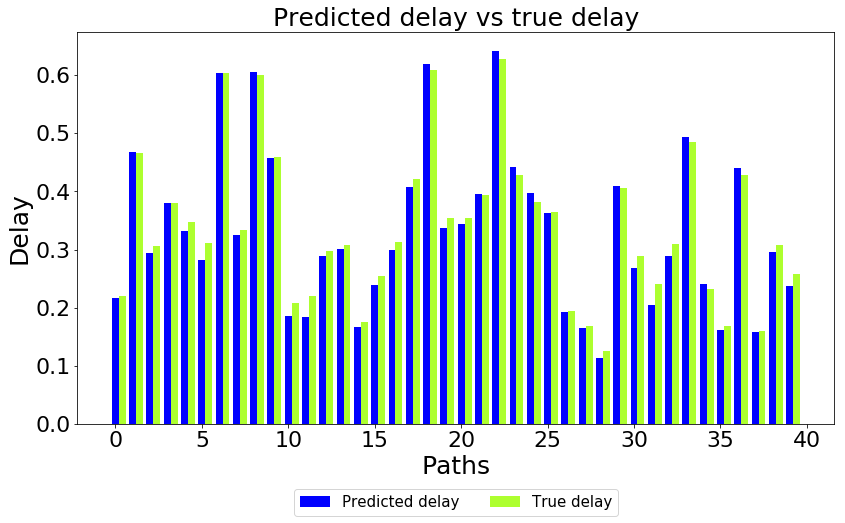

In [6]:
# create plot
fig, ax = plt.subplots()
index = np.arange(num_paths)
bar_width = 0.40

rects1 = plt.bar(index, sample_prediction, bar_width,
color='b',
label='Predicted delay')

rects2 = plt.bar(index + bar_width, sample_label, bar_width,
color='greenyellow',
label='True delay')

for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(22)
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(22)

plt.xlabel('Paths',fontsize=25)
plt.ylabel('Delay',fontsize=25)
plt.title('Predicted delay vs true delay',fontsize=25)
plt.legend(loc='center',fontsize=15,bbox_to_anchor=(0.5, -0.20),fancybox=True,ncol=2)
plt.tight_layout()

fig = plt.gcf()
fig.set_size_inches(14, 8.5)

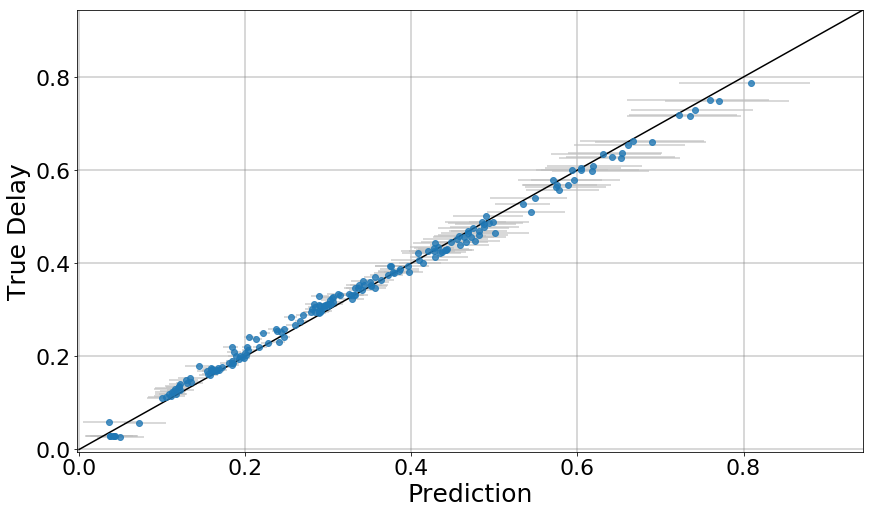

In [7]:
ax = plt.subplot()

xerr = [final_prediction - np.percentile(predicted_delays, q=5, axis=0),
        np.percentile(predicted_delays, q=95, axis=0) - final_prediction]

ax.errorbar(x=final_prediction, y=true_delay[0], fmt='o', xerr=xerr, alpha=0.8, ecolor='silver')

m = max(true_delay[0])
ax.plot([0, 1.3 * m], [0, 1.3 * m], 'k')
ax.grid(color='gray', linestyle='-', linewidth=2, alpha=0.3)
ax.set_xlabel('Prediction', fontsize=25)
ax.set_ylabel('True Delay', fontsize=25)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(22)
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(22)
ax.set_xlim(left=-0.002, right=1.2 * m)
ax.set_ylim(bottom=-0.005, top=1.2 * m)
fig = plt.gcf()
plt.tight_layout()
fig.set_size_inches(14, 8.5)

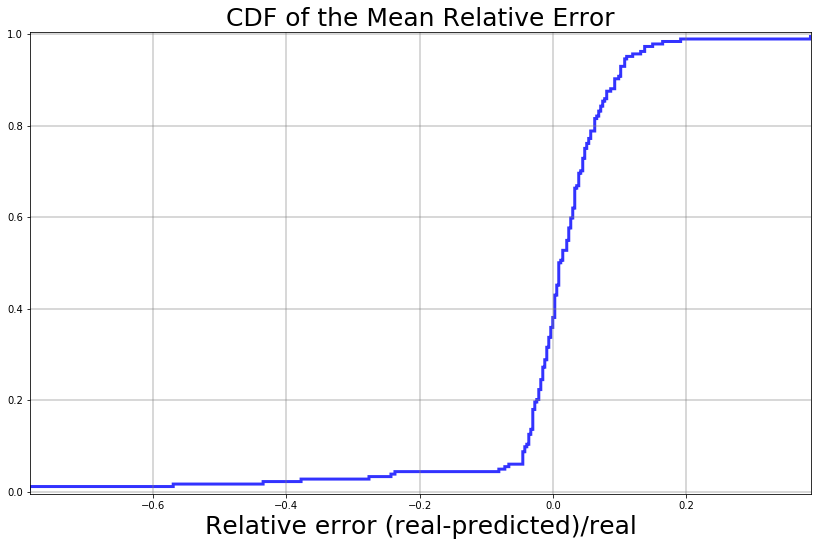

In [8]:
def frange(x, y, jump):
  while x < y:
    yield x
    x += jump

mre = (true_delay-final_prediction)/true_delay
mre = np.sort(mre)

mre = np.insert(mre, 0, -15.0)
mre = np.append(mre, 15.0)

plt.hist(mre, cumulative=True, 
         histtype='step', 
         bins=10000, 
         alpha=0.8, 
         color='blue', 
         density=True, 
         linewidth=3)
plt.ylim((-0.005, 1.005))
plt.xlim((mre[1], mre[-2]))
plt.xlabel("Relative error (real-predicted)/real", fontsize=25)
plt.rc('xtick',labelsize=22)
plt.rc('ytick',labelsize=22)
plt.grid(color='gray', linestyle='-', linewidth=2, alpha=0.3)
plt.title('CDF of the Mean Relative Error',fontsize=25)
fig = plt.gcf()
fig.set_size_inches(14, 8.5)

# References

Rusek, K., Suárez-Varela, J., Mestres, A., Barlet-Ros, P., & Cabellos-Aparicio, A. (2019, April). 
Unveiling the potential of Graph Neural Networks for network modeling and optimization in SDN. 
In Proceedings of the 2019 ACM Symposium on SDN Research (pp. 140-151). ACM.

In [9]:
#@title Licensed under the MIT License (the "License"); { display-mode:"form" }
# MIT License

# Copyright (c) 2019 Paul Almasan, José Suárez-Varela, Krzysztzof Rusek

# Permission is hereby granted, free of charge, to any person obtaining a copy
# of this software and associated documentation files (the "Software"), to deal
# in the Software without restriction, including without limitation the rights
# to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
# copies of the Software, and to permit persons to whom the Software is
# furnished to do so, subject to the following conditions:

# The above copyright notice and this permission notice shall be included in all
# copies or substantial portions of the Software.

# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
# AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
# OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
# SOFTWARE.

